# Clustering neighborhoods of Groningen, the Netherlands
### Finding optimal bar or restaurant locations near the city center

Jamo Momand, December 31th 2020, IBM Applied Data Science Capstone

## Table of Contents

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

For the IBM Applied Data Science Capstone, I am going to search for **optimal new bar/restaurant locations** in the student city **Groningen, the Netherlands**. The target audience will be **prospective bar/restaurant owners**.

Groningen is the largest city in the north of the Netherlands. It has a population of approximately 200k, of which 50% are below the age of 30. Since the city’s university and higher education hosts more than 60k students, it is a vibrant student city with a multitude of bars and restaurants. This is why there are plenty of opportunities for the nightlife industry and henceforth my choice of business problem. See the video in the link below for a visual background sketch.

https://www.youtube.com/watch?v=05Iiuz7A7E0

I will search for bars and restaurants at the edge of the most competitive regions, because I expect that while the Corona virus situation will slowly be resolved in 2021, the city center will be very competitive for new players on the market.

## Data <a name="data"></a>

**Neighborhood data**: I will define neighborhoods used for the analysis as is done by the municipality of Groningen. Examples are the names of the neighborhoods, like Binnenstad or A-Kwartier.

https://gemeente.groningen.nl/wijken-dorpen-wijkwethouders-en-gebiedsteams

**Coordinate data**: Next, I will search the neighborhood coordinates using the free geolocator Nominatim from GeoPy. The neighborhoods that cannot be found, will be excluded from analysis. If necessary, the neighborhood and coordinate data will be cleaned to discard irrelevant or erroneous neighborhoods.

**Venue data**: This will be requested from Foursquare. Examples of venues are bars or restaurants and their geographical locations. If necessary, a selection will be made of which venues to select. However, not only bars and restaurants should be included in the analysis, as other venues like supermarkets or gyms can be indicators of livelihood and thus business opportunities.

## Methodology <a name="methodology"></a>

This data will then be processed (cleaned/selected) and included in a clustering analysis, similarly to the examples of the IBM course. For this, I will use KMeans and will identify the most competitive region and its nearby neighborhoods, after which I will classify them in competitive order besides the city center. This will then be my advice to the newcomer to the nightlife market as where to start the bar/restaurant business.

## Results and Discussion  <a name="results"></a>

In [1]:
# Imports that are used frequently throughout the notebook
import folium
import numpy as np
import pandas as pd

### Exploring the city of Groningen

First, let’s explore Groningen on the map. I will use the free geolocator Nominatim from GeoPy and Folium for coordinates and maps, respectively. If everything works correctly, the output should be a map of Groningen like below.

In [2]:
# Function to get the coordinates of a given search query
from geopy import distance
from geopy.geocoders import Nominatim

def getCoordinates(search):
    geolocator = Nominatim(user_agent="Groningen Project")
    return geolocator.geocode(search)

In [3]:
# Search for the city of Groningen and display results
search = 'Groningen'
location = getCoordinates(search)

city_name = location.raw['display_name']
city_lat = location.latitude
city_lon = location.longitude

city_name, city_lat, city_lon

('Groningen, Nederland', 53.2190652, 6.5680077)

In [4]:
# Display the results on the map with Folium
city_map = folium.Map(location=[city_lat, city_lon], control_scale=True, zoom_start=12)
city_map

### Load neighborhood names of Groningen

Next, I will scrape neighborhood names from Groningen municipality website. Some data cleaning steps are performed, because known neighborhoods are omitted and there are some typos on the website. As this is not a robust function against website updates, I store and load previous results. The results will be stored in a Pandas DataFrame. The results will be stored as a Pandas DataFrame object, like below:

In [5]:
# Function to scrape the municipality website for the neighborhood names
import requests
import datetime
from os import listdir
from bs4 import BeautifulSoup

def getNewNeighborhoods(save=False):
    # Get HTML
    url='https://gemeente.groningen.nl/wijken-dorpen-wijkwethouders-en-gebiedsteams'
    
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    page.close()
    
    # Get areas and names of neighborhoods
    areas = [elem.getText() for elem in soup.findAll('h3')][0:7]
    nhoods = [elem.getText().strip('.') for elem in soup.findAll('p')][8:15]
    
    # Data cleaning, i.e. manually correcting textual errors and adding known neighborhoods
    neighborhoods = []
    for idx, area in enumerate(areas):
        hoods = nhoods[idx] \
        .replace(' en ', ',') \
        .replace('(', ',') \
        .replace(')', '') \
        .replace('Noorderhoogebrug', 'Noorderhoogebrug,') \
        .replace('Europapark', 'Europapark,Euvelgunne,Stadspark') \
        .replace('Paddepoel', 'Paddepoel Winkelcentrum') \
        .replace('Selwerd', 'Selwerd Eikenlaan') \
        .replace('Oranjebuurt', 'Oranjewijk') \
        .replace('Reitdiep', 'Reitdiephaven, Zernike Campus') \
        .split(',')
        
        hoods = [hood.strip(' ') for hood in hoods]
        
        for hood in hoods:
            neighborhoods.append((area, hood))
    
    # Create pandas DataFrame
    neighborhoods = pd.DataFrame(neighborhoods, columns=['Area', 'Neighborhood'])
    
    # Saving the data to not request it every time
    if save == True:
        date_time = datetime.datetime.now().strftime("%Y-%m-%d %H%M")
        name = 'Data/Neighborhood Groningen ' + date_time + '.csv'
        neighborhoods.to_csv(name, index = False, header=True)
    
    return neighborhoods

# Function to laod the neighborhood names
def loadNeighborhoods():
    path = 'Data/'
    name = 'Neighborhood Groningen'
    file_list = sorted(listdir('Data/'), reverse=True)
    
    for file in file_list:
        if name in file:
            return pd.read_csv(path + file)
            break
    
    return getNewNeighborhoods(save=True)

In [6]:
#getNewNeighborhoods(save=True)

neighborhood_names = loadNeighborhoods()
neighborhood_names

,Area,Neighborhood
0,Haren,Glimmen
1,Haren,Haren
2,Haren,Noordlaren
3,Haren,Onnen
4,Ten Boer,Garmerwolde
...,...,...
74,West,Reitdiephaven
75,West,Zernike Campus
76,West,Selwerd Eikenlaan
77,West,Tuinwijk


### Load coordinates of neighborhoods

As stated previously, I will search the neighborhood coordinates using the free geolocator Nominatim from GeoPy and store the results in a Pandas DataFrame. In addition, I will add the distance from the city center. The output should be as shown below.

In [7]:
# Function to get coordinates for the neighborhood names
def getNewCoordinates(neighborhoods, center='Groningen', save=False):
    # Try to find coordinates
    coordinates = []
    
    for hood in neighborhoods.Neighborhood:
        search = ', '.join([hood, city_name])
        location = getCoordinates(search)
        
        if location != None:
            loc_lat, loc_lon = location.latitude, location.longitude
            from_cntr = distance.distance((city_lat, city_lon), (loc_lat, loc_lon)).km
            coordinates.append((hood, loc_lat, loc_lon, from_cntr))
    
    # Create pandas DataFrame
    coordinates = pd.DataFrame(coordinates, columns=['Neighborhood', 'Latitude', 'Longitude', 'From Center'])
    
    # Saving the data to not request it every time
    if save == True:
        date_time = datetime.datetime.now().strftime("%Y-%m-%d %H%M")
        name = 'Data/Coordinates Groningen ' + date_time + '.csv'
        coordinates.to_csv(name, index = False, header=True)
    
    return coordinates

# Function to laod the neighborhood coordinates
def loadCoordinates(neighborhoods):
    path = 'Data/'
    name = 'Coordinates Groningen'
    file_list = sorted(listdir('Data/'), reverse=True)
    
    for file in file_list:
        if name in file:
            return pd.read_csv(path + file)
            break
    
    return getNewCoordinates(neighborhoods, save=True)

In [8]:
#getNewCoordinates(neighborhood_names, save=True)

coordinates = loadCoordinates(neighborhood_names)
coordinates

,Neighborhood,Latitude,Longitude,From Center
0,Glimmen,53.138727,6.628281,9.807001
1,Haren,53.170984,6.606141,5.926898
2,Noordlaren,53.120837,6.666759,12.771623
3,Onnen,53.157646,6.641260,8.408229
4,Garmerwolde,53.247471,6.648617,6.242335
...,...,...,...,...
72,Reitdiephaven,53.237821,6.525955,3.499093
73,Zernike Campus,53.245725,6.530004,3.904206
74,Selwerd Eikenlaan,53.233120,6.553443,1.841958
75,Tuinwijk,53.229026,6.552483,1.517904


### Evaluate neighborhoods and coordinates

These DataFrames are then merged, omitting neighborhood names that are not found. This results in the DataFrame in Figure 4 and the map in Figure 5. The average distance and its standard deviation are: 3.95 km and 3.63 km.

Visual inspection of the neighborhoods shows that there is a good agreement (which was partially the result of cleaning of neighborhood names). One could choose to discard the neighborhoods far from the center in later steps, not being relevant to the city culture, but I chose to keep it as to see what the analysis will show for it.

In [9]:
# Merge neighborhood names and coordinates to 1 DataFrame
neighborhoods = neighborhood_names.join(coordinates.set_index('Neighborhood'), on='Neighborhood')
neighborhoods = neighborhoods[neighborhoods['Latitude'].notnull()]
neighborhoods

,Area,Neighborhood,Latitude,Longitude,From Center
0,Haren,Glimmen,53.138727,6.628281,9.807001
1,Haren,Haren,53.170984,6.606141,5.926898
2,Haren,Noordlaren,53.120837,6.666759,12.771623
3,Haren,Onnen,53.157646,6.641260,8.408229
4,Ten Boer,Garmerwolde,53.247471,6.648617,6.242335
...,...,...,...,...,...
74,West,Reitdiephaven,53.237821,6.525955,3.499093
75,West,Zernike Campus,53.245725,6.530004,3.904206
76,West,Selwerd Eikenlaan,53.233120,6.553443,1.841958
77,West,Tuinwijk,53.229026,6.552483,1.517904


In [10]:
# Define the map object
city_map = folium.Map(location=[city_lat, city_lon], control_scale=True, zoom_start=11)

# Set a marker for each neighborhood
for lat, lon, area, hood, dist in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Area'], neighborhoods['Neighborhood'], neighborhoods['From Center']):
    label = '{}, {}, {:2.1f} km'.format(hood, area, dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.5,
        parse_html = False).add_to(city_map)

# Display map
city_map

In [11]:
# Calculate average distance and standard deviation from city center
ave_dst = neighborhoods['From Center'].mean()
std_dst = neighborhoods['From Center'].std()

print('The average distance and its standard deviation are: {:.2f} km and {:.2f} km'.format(ave_dst, std_dst))

The average distance and its standard deviation are: 3.95 km and 3.63 km


### Load venues from Foursquare

Finally, I use Foursquare to find venues within a radius of 1 km of each neighborhood. Examples of venues are bars and restaurants with their coordinates, but also supermarkets, gyms, etc. I chose 1 km because of the Groningen cycling culture, where 1 km is approximately a 4 min bicycle ride and 12 minute walk. The results are stored in a Pandas DataFrame, as below.

A couple of notes should be made on the data here. First, one could do a lot of data cleaning here. E.g. one could choose to discard a Forest or merge Restaurant with Brasserie in Glimmen. This could be done when finetuning the analysis, but I leave it as is for the course assignment. Second, the free Foursquare account has a limit of 100 venues per request, which is clearly visible for neighborhood near the city center. I leave it as is, but for finetuning the analysis one could define denser location data when this happens.

In [12]:
# Insert your client id and secret to get new requests
CLIENT_ID = 'CLIENT_ID'
CLIENT_SECRET = 'CLIENT_SECRET'
VERSION = 20201209
LIMIT = 100

In [13]:
# Function to get venues in the vicinity of the neighborhoods
def getNewVenues(neighborhoods, radius=500, save=False):
    venues_list=[]
    
    for name, lat, lng, dst in zip(neighborhoods['Neighborhood'], neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['From Center']):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
               CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, dst,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'From Center',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']
    
    # Saving the data to not request it every time
    if save == True:
        date_time = datetime.datetime.now().strftime("%Y-%m-%d %H%M")
        name = 'Data/Venues Groningen ' + date_time + ' Radius=' + str(radius) + '.csv'
        nearby_venues.to_csv(name, index = False, header=True)
    
    return nearby_venues

# Function to laod the neighborhood venues
def loadVenues(neighborhoods, radius):
    path = 'Data/'
    name = 'Venues Groningen'
    file_list = sorted(listdir('Data/'), reverse=True)
    
    for file in file_list:
        if name in file and '=' + str(radius) in file:
            return pd.read_csv(path + file)
            break
    
    return getNewVenues(neighborhoods, radius, save=True)

In [14]:
#getNewVenues(neighborhoods, radius=500, save=True)
#getNewVenues(neighborhoods, radius=1000, save=True)
#getNewVenues(neighborhoods, radius=1500, save=True)
#getNewVenues(neighborhoods, radius=2000, save=True)
#getNewVenues(neighborhoods, radius=2500, save=True)

venues = loadVenues(neighborhoods, radius=1000)
venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,From Center,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Glimmen,53.138727,6.628281,9.794678,Appelbergen,53.138386,6.637230,Forest
1,Glimmen,53.138727,6.628281,9.794678,Paviljoen Appelbergen,53.136574,6.639588,Restaurant
2,Glimmen,53.138727,6.628281,9.794678,Voetbal Vereniging Glimmen,53.143628,6.628064,Soccer Field
3,Glimmen,53.138727,6.628281,9.794678,Flora & Fauna,53.144463,6.625756,Flower Shop
4,Glimmen,53.138727,6.628281,9.794678,Brasserie de Kastanjehoeve,53.132521,6.630713,Brasserie
...,...,...,...,...,...,...,...,...
2447,Vinkhuizen,53.226659,6.527400,2.832159,Siersteenlaan,53.224113,6.519835,Grocery Store
2448,Vinkhuizen,53.226659,6.527400,2.832159,Bushalte Voermanstraat,53.227827,6.537814,Bus Stop
2449,Vinkhuizen,53.226659,6.527400,2.832159,Bushalte Goudlaan,53.222332,6.535212,Bus Stop
2450,Vinkhuizen,53.226659,6.527400,2.832159,Roege Bos,53.222563,6.516508,Forest


### One Hot encoding, grouping and normalizing

Now that the data is complete, I perform the analysis. The venue data is One Hot coded, grouped by neighborhood and summed. Here is an additional point where one can finetune the analysis. My choice was just summing the number of venues with equal weight for simplicity, but also here one could give bars and restaurants a bigger weight than e.g. a forest.

In [15]:
# One hot coding of the venues
groningen_onehot = pd.get_dummies(venues[['Venue Category']], prefix='', prefix_sep='')

# Set neighborhood names in 1st column
groningen_onehot.pop('Neighborhood')
groningen_onehot.insert(0, 'Neighborhood', venues['Neighborhood'])

# Sum all the venues for each neighborhood
groningen_grouped = groningen_onehot.groupby('Neighborhood').sum().reset_index()
groningen_grouped

,Neighborhood,Accessories Store,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Thrift / Vintage Store,Track,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop
0,A-Kwartier,0,0,1,0,0,1,0,0,0,...,0,0,0,2,1,0,0,1,1,0
1,Badstratenbuurt,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,Beijum,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Binnenstad,0,0,1,0,0,2,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,Binnenstad-Oost,0,0,0,0,0,2,0,0,0,...,0,0,0,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Winneweer,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,Woltersum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,Woonschepenhaven,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
72,Zeeheldenbuurt,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [16]:
# Find number of venues, bars and restaurants for each neighborhood
data_barrest = []

for idx in range(len(groningen_grouped)):
    tmp = groningen_grouped.loc[idx, 'Neighborhood'], \
          groningen_grouped.sum(1).iloc[idx], \
          groningen_grouped.loc[idx, 'Bar'], \
          groningen_grouped.loc[idx, 'Restaurant']
    
    data_barrest.append(tmp)

# Create a pandas DataFrame
data_barrest = pd.DataFrame(data_barrest, columns=['Neighborhood', 'Venues', 'Bars', 'Restaurants'])
data_barrest

,Neighborhood,Venues,Bars,Restaurants
0,A-Kwartier,100,5,9
1,Badstratenbuurt,100,6,5
2,Beijum,18,0,0
3,Binnenstad,100,5,10
4,Binnenstad-Oost,100,4,9
...,...,...,...,...
69,Winneweer,4,0,0
70,Woltersum,3,0,0
71,Woonschepenhaven,24,1,1
72,Zeeheldenbuurt,88,6,3


### Clustering

As stated before, I will use KMeans for clustering. To find the optimal number of clusters I use the elbow method as implemented in the Yellowbrick library, see below. Several runs gives values between 5 and 11 clusters, so I choose to set the number of clusters to 8 and perform KMeans.

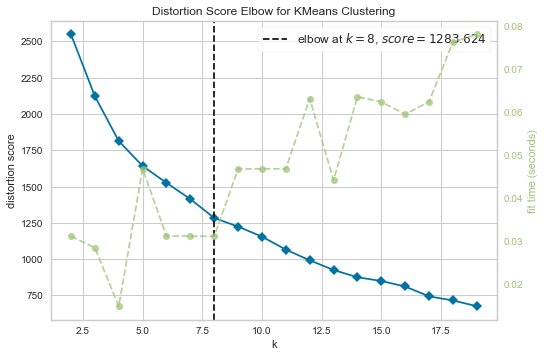

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
# Use the elbow method from the yellowbrick package to find optimal number of KMeans clusters
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 20))

groningen_grouped_clustering = groningen_grouped.drop('Neighborhood', 1)
visualizer.fit(groningen_grouped_clustering)
visualizer.show()

In [18]:
# Perform KMeans with optimal number of clusters
kclusters = 8
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(groningen_grouped_clustering)

Combining everything, the data and results give the map below. Visual inspection of the results shows that cluster 7 is the inner city center, which will be used to answer the business problem in the introduction. Cluster 5 and 0 are living areas or areas where there are very few venues, respectively. One can omit these clusters to get the final recommendation results in below.

The colors indicate: Purple – 0, Red – 1, Dark Blue – 2, Blue – 3, Light Blue – 4, Green – 5, Beige – 6, Orange – 7.

In [19]:
# Insert cluster labels
try:
    data_barrest.pop('Cluster Label')
    data_barrest.insert(1, 'Cluster Label', kmeans.labels_)
except:
    data_barrest.insert(1, 'Cluster Label', kmeans.labels_)

# Merge neighborhood data, cluster labels and number of venues, bars and restaurants
groningen_merged = neighborhoods
groningen_merged = groningen_merged.join(data_barrest.set_index('Neighborhood'), on='Neighborhood')
groningen_merged = groningen_merged[groningen_merged['Cluster Label'].notnull()]
groningen_merged

,Area,Neighborhood,Latitude,Longitude,From Center,Cluster Label,Venues,Bars,Restaurants
0,Haren,Glimmen,53.138727,6.628281,9.807001,0.0,7.0,0.0,1.0
1,Haren,Haren,53.170984,6.606141,5.926898,5.0,23.0,0.0,1.0
2,Haren,Noordlaren,53.120837,6.666759,12.771623,0.0,4.0,0.0,0.0
3,Haren,Onnen,53.157646,6.641260,8.408229,0.0,4.0,0.0,0.0
4,Ten Boer,Garmerwolde,53.247471,6.648617,6.242335,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
74,West,Reitdiephaven,53.237821,6.525955,3.499093,5.0,15.0,0.0,1.0
75,West,Zernike Campus,53.245725,6.530004,3.904206,0.0,4.0,0.0,0.0
76,West,Selwerd Eikenlaan,53.233120,6.553443,1.841958,2.0,32.0,0.0,1.0
77,West,Tuinwijk,53.229026,6.552483,1.517904,2.0,56.0,2.0,3.0


In [20]:
# Visualize the results
import matplotlib.cm as cm
import matplotlib.colors as colors

# Create map
map_clusters = folium.Map(location=[city_lat, city_lon], control_scale=True, zoom_start=12)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(groningen_merged['Latitude'], groningen_merged['Longitude'], groningen_merged['Neighborhood'], groningen_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    cluster = int(cluster)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [21]:
# Calculate for each cluster the average number of venues, bars and restaurants
results = []

for idx in range(kclusters):
    results.append(data_barrest[data_barrest['Cluster Label'] == idx].mean().values.tolist())

results = pd.DataFrame(results, columns=['Cluster Label', 'Venues', 'Bars', 'Restaurants']).round(1).set_index('Cluster Label')
results

,Venues,Bars,Restaurants
Cluster Label,,,
0.0,7.6,0.1,0.3
1.0,100.0,5.5,6.5
2.0,44.6,0.7,1.6
3.0,61.5,3.0,2.0
4.0,96.0,6.7,4.7
5.0,18.7,0.3,0.3
6.0,56.6,4.2,4.2
7.0,100.0,5.6,9.4


### Optimal neighborhoods

Of course it is up to the prospective bar or restaurant owner here to decide whether more venues will be beneficiary (more livelihood) or whether fewer would be better to open a niche bar or restaurant. Such a question could be further explored if this is a requirement for the business problem.

In [22]:
# Showing results for optimal bar locations beside the city center
results.sort_values('Bars', ascending=False).drop(7, 0).drop(0, 0).drop(5, 0)

,Venues,Bars,Restaurants
Cluster Label,,,
4.0,96.0,6.7,4.7
1.0,100.0,5.5,6.5
6.0,56.6,4.2,4.2
3.0,61.5,3.0,2.0
2.0,44.6,0.7,1.6


In [23]:
# Showing results for optimal restaurant locations beside the city center
results.sort_values('Restaurants', ascending=False).drop(7, 0).drop(0, 0).drop(5, 0)

,Venues,Bars,Restaurants
Cluster Label,,,
1.0,100.0,5.5,6.5
4.0,96.0,6.7,4.7
6.0,56.6,4.2,4.2
3.0,61.5,3.0,2.0
2.0,44.6,0.7,1.6


### Optimal neighborhood names

In [24]:
groningen_merged[groningen_merged['Cluster Label'] == 1]

,Area,Neighborhood,Latitude,Longitude,From Center,Cluster Label,Venues,Bars,Restaurants
16,Centrum,Hortusbuurt,53.223298,6.560240,0.700791,1.0,100.0,6.0,5.0
17,Centrum,Ebbingekwartier,53.225259,6.564718,0.723520,1.0,100.0,5.0,8.0


In [25]:
groningen_merged[groningen_merged['Cluster Label'] == 4]

,Area,Neighborhood,Latitude,Longitude,From Center,Cluster Label,Venues,Bars,Restaurants
27,Oude Wijken,Schildersbuurt,53.217009,6.552060,1.089580,4.0,100.0,8.0,6.0
44,Zuid,Badstratenbuurt,53.212219,6.556935,1.061899,4.0,100.0,6.0,5.0
62,Zuid,Zeeheldenbuurt,53.212436,6.551758,1.312470,4.0,88.0,6.0,3.0


In [26]:
groningen_merged[groningen_merged['Cluster Label'] == 6]

,Area,Neighborhood,Latitude,Longitude,From Center,Cluster Label,Venues,Bars,Restaurants
50,Zuid,Herewegbuurt,53.208134,6.575120,1.306047,6.0,48.0,5.0,2.0
54,Zuid,Rivierenbuurt,53.207523,6.567762,1.284651,6.0,49.0,5.0,2.0
56,Zuid,De Linie,53.207420,6.583421,1.655258,6.0,35.0,4.0,1.0
64,Zuid,De Meeuwen,53.213539,6.582364,1.139320,6.0,70.0,4.0,7.0
66,Zuid,Kop van Oost,53.217271,6.583753,1.070529,6.0,81.0,3.0,9.0


In [27]:
groningen_merged[groningen_merged['Cluster Label'] == 3]

,Area,Neighborhood,Latitude,Longitude,From Center,Cluster Label,Venues,Bars,Restaurants
26,Oude Wijken,Oranjewijk,53.221382,6.547895,1.367971,3.0,63.0,5.0,2.0
28,Oude Wijken,Kostverloren,53.216322,6.543488,1.666100,3.0,52.0,2.0,2.0
47,Zuid,Grunobuurt,53.206615,6.559757,1.491159,3.0,65.0,2.0,2.0
53,Zuid,Laanhuizen,53.208803,6.553147,1.513285,3.0,66.0,3.0,2.0


In [28]:
groningen_merged[groningen_merged['Cluster Label'] == 2]

,Area,Neighborhood,Latitude,Longitude,From Center,Cluster Label,Venues,Bars,Restaurants
20,Oude Wijken,De Hoogte,53.233516,6.561357,1.668422,2.0,25.0,0.0,0.0
21,Oude Wijken,Korrewegwijk,53.231474,6.570668,1.392388,2.0,39.0,0.0,0.0
22,Oude Wijken,Indische buurt,53.230663,6.563701,1.322423,2.0,48.0,1.0,2.0
23,Oude Wijken,Professorenbuurt,53.230838,6.573988,1.369762,2.0,36.0,0.0,0.0
24,Oude Wijken,Noorderplantsoenbuurt,53.226514,6.553569,1.271718,2.0,76.0,2.0,5.0
76,West,Selwerd Eikenlaan,53.233120,6.553443,1.841958,2.0,32.0,0.0,1.0
77,West,Tuinwijk,53.229026,6.552483,1.517904,2.0,56.0,2.0,3.0


## Conclusion <a name="conclusion"></a>

In summary, for the IBM Applied Data Science Capstone I have defined a business problem to find optimal bar and restaurant locations in the city of Groningen, the Netherlands. For this, I have used neighborhood data from the municipality website and Foursquare venue data. Using KMeans clustering from ScikitLearn and an optimal cluster size from Yellowbrick, the optimal bar and restaurant locations are found and given in Figures 9 and 10, respectively. Different data cleaning and optimizing steps, as well as analysis steps, are discussed in between. With this, the business problem is answered and an advise to prospective bar or restaurant owners can be given.